In [1]:
using CSV
using PyPlot
using Dates
using DelimitedFiles, DataFrames
const plt = PyPlot
using Conda
using PyCall
mpl = pyimport("matplotlib")
mpl.style.use("./emodnet.mplstyle")
ccrs = pyimport("cartopy.crs")
datacrs = ccrs.PlateCarree();

## Data
Downloaded from https://www.vliz.be/en/imis?module=dataset&dasid=3117. 

> Vanermen N, Stienen EWM, Fijn R, Markones N, Holdsworth N, Osypchuk A, Pinto C, Desmet P (2022): European Seabirds at Sea (ESAS). ICES, Copenhagen, Denmark. https://esas.ices.dk. https://doi.org/10.14284/601

Two files are processed:
- `event.txt`: it gives the data set ID, the position and the date
- `occurrence.txt`: it gives the count for different taxa, and relate them to the eventID read from the previous fole. 

In [2]:
domain = (-55, 21, 14., 80.)
doplot = false

datadir = "/home/ctroupin/data/EMODnet/Biology/dwca-esas-v1.3"
datafileevent = joinpath(datadir, "event.txt")
datafileevent2 = joinpath(datadir, "event_small.txt")
datafileoccur = joinpath(datadir, "occurrence.txt")
isfile(datafileevent) & isfile(datafileoccur)

true

In [3]:
function read_data_event(datafile::AbstractString, thedateformat=dateformat"y-m-dTH:M:SZ")
    open(datafile, "r") do df
        firstline = readline(df)
        column_names = split(firstline, "\t")
        
        ncolumns = length(column_names)
        @info("Number of columns: $(ncolumns)")
        
        lon_column = findfirst(occursin.("decimalLongitude", column_names))
        lat_column = findfirst(occursin.("decimalLatitude", column_names))
        date_column = findfirst(occursin.("eventDate", column_names))
        id_column = findfirst(occursin.("eventID", column_names))
        
        @info("Column index for longitude: $(lon_column); for latitude: $(lat_column)")
        
        lon = Float64[]
        lat = Float64[]
        dates = Dates.DateTime[]
        eventID = String[]
        
        for lines in readlines(df)
            linesplit = split(lines, "\t")
            
            if linesplit[2] == "subSample"
                push!(lon, parse(Float64, linesplit[lon_column]))
                push!(lat, parse(Float64,linesplit[lat_column]))
                push!(dates, DateTime(linesplit[date_column], thedateformat))
                push!(eventID, linesplit[id_column])
            end
        end
        
        
        return lon::Array{Float64}, lat::Array{Float64}, dates::Vector{DateTime}, eventID::Vector{String}
    end
end

read_data_event (generic function with 2 methods)

In [4]:
@time lon, lat, dates, eventID = read_data_event(datafileevent);

[ Info: Number of columns: 15
[ Info: Column index for longitude: 13; for latitude: 12


  5.585587 seconds (11.37 M allocations: 2.742 GiB, 17.27% gc time, 22.36% compilation time)


## Make some plots
### Histogram

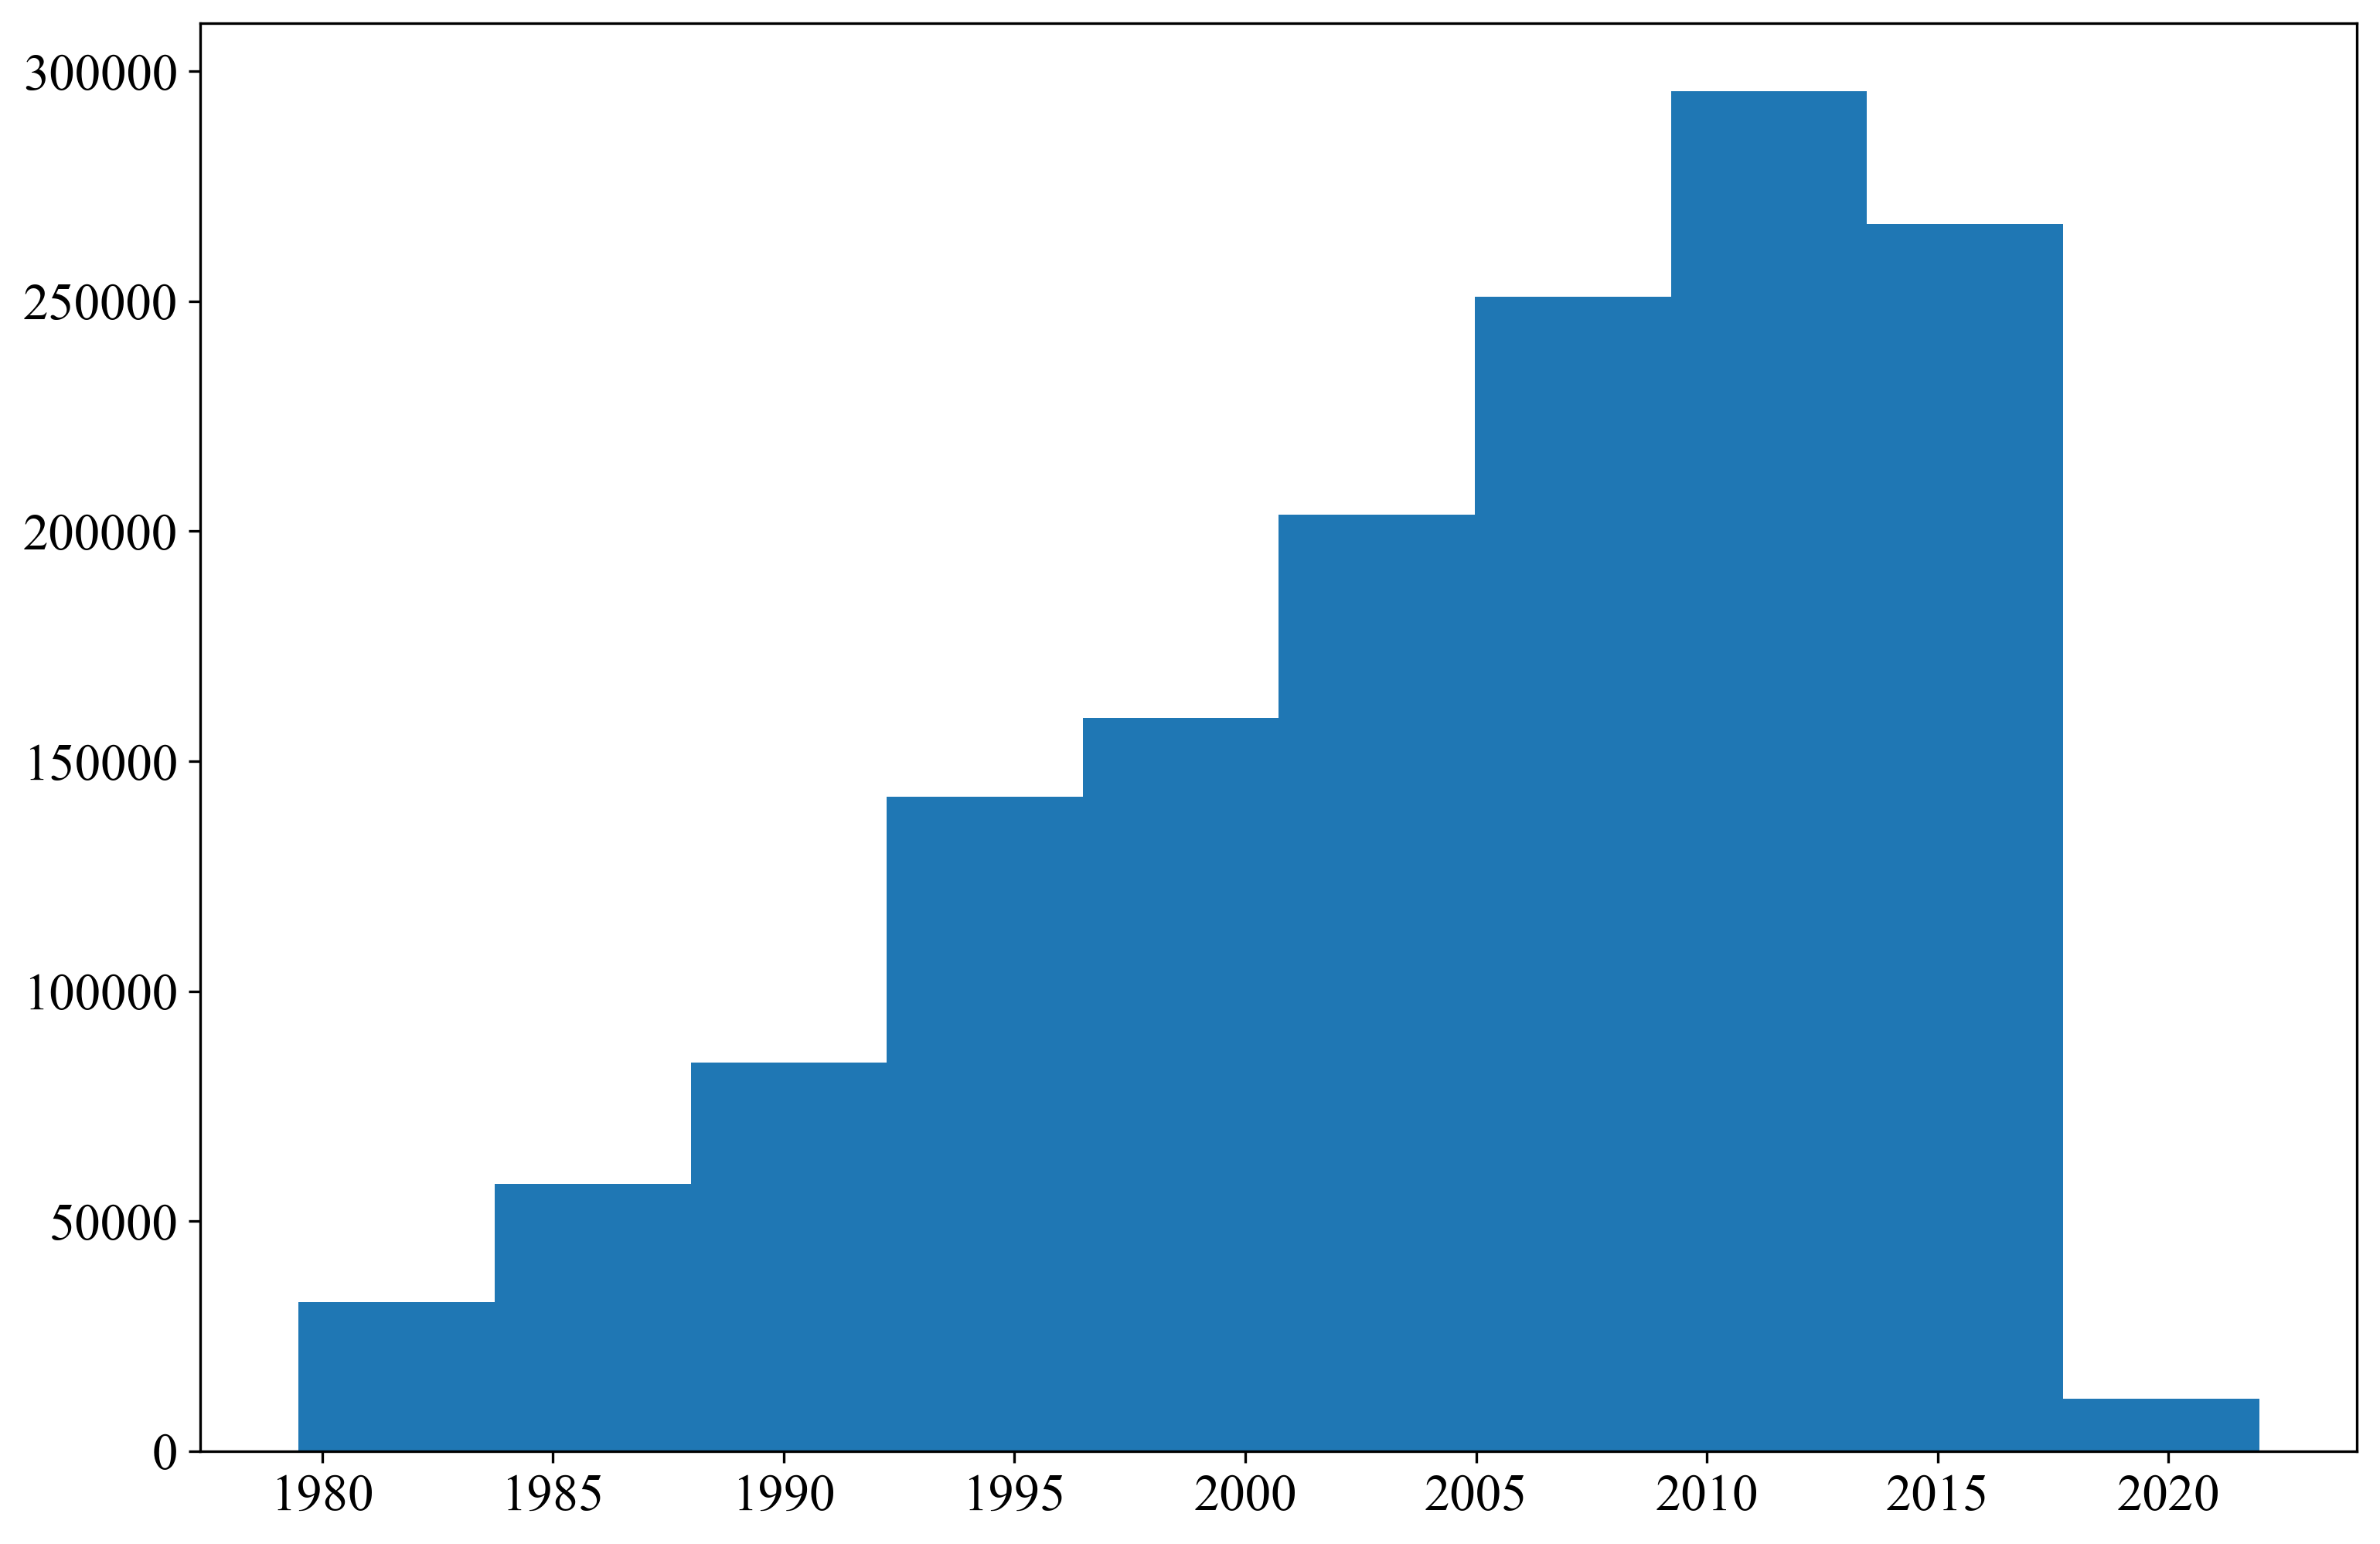

([32345.0, 58132.0, 84448.0, 142336.0, 159463.0, 203599.0, 250976.0, 295691.0, 266718.0, 11326.0], [3466.7430555555557, 5017.931527777779, 6569.120000000001, 8120.308472222224, 9671.496944444447, 11222.685416666667, 12773.873888888891, 14325.062361111115, 15876.250833333335, 17427.43930555556, 18978.62777777778], (PyObject <matplotlib.patches.Rectangle object at 0x790e1023e940>, PyObject <matplotlib.patches.Rectangle object at 0x790e1023e970>, PyObject <matplotlib.patches.Rectangle object at 0x790e1023eee0>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0130>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0340>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0550>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0760>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0970>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0b80>, PyObject <matplotlib.patches.Rectangle object at 0x790dffec0d90>))

In [5]:
fig = plt.figure()
ax = plt.subplot(111)
ax.hist(dates)

### Locations

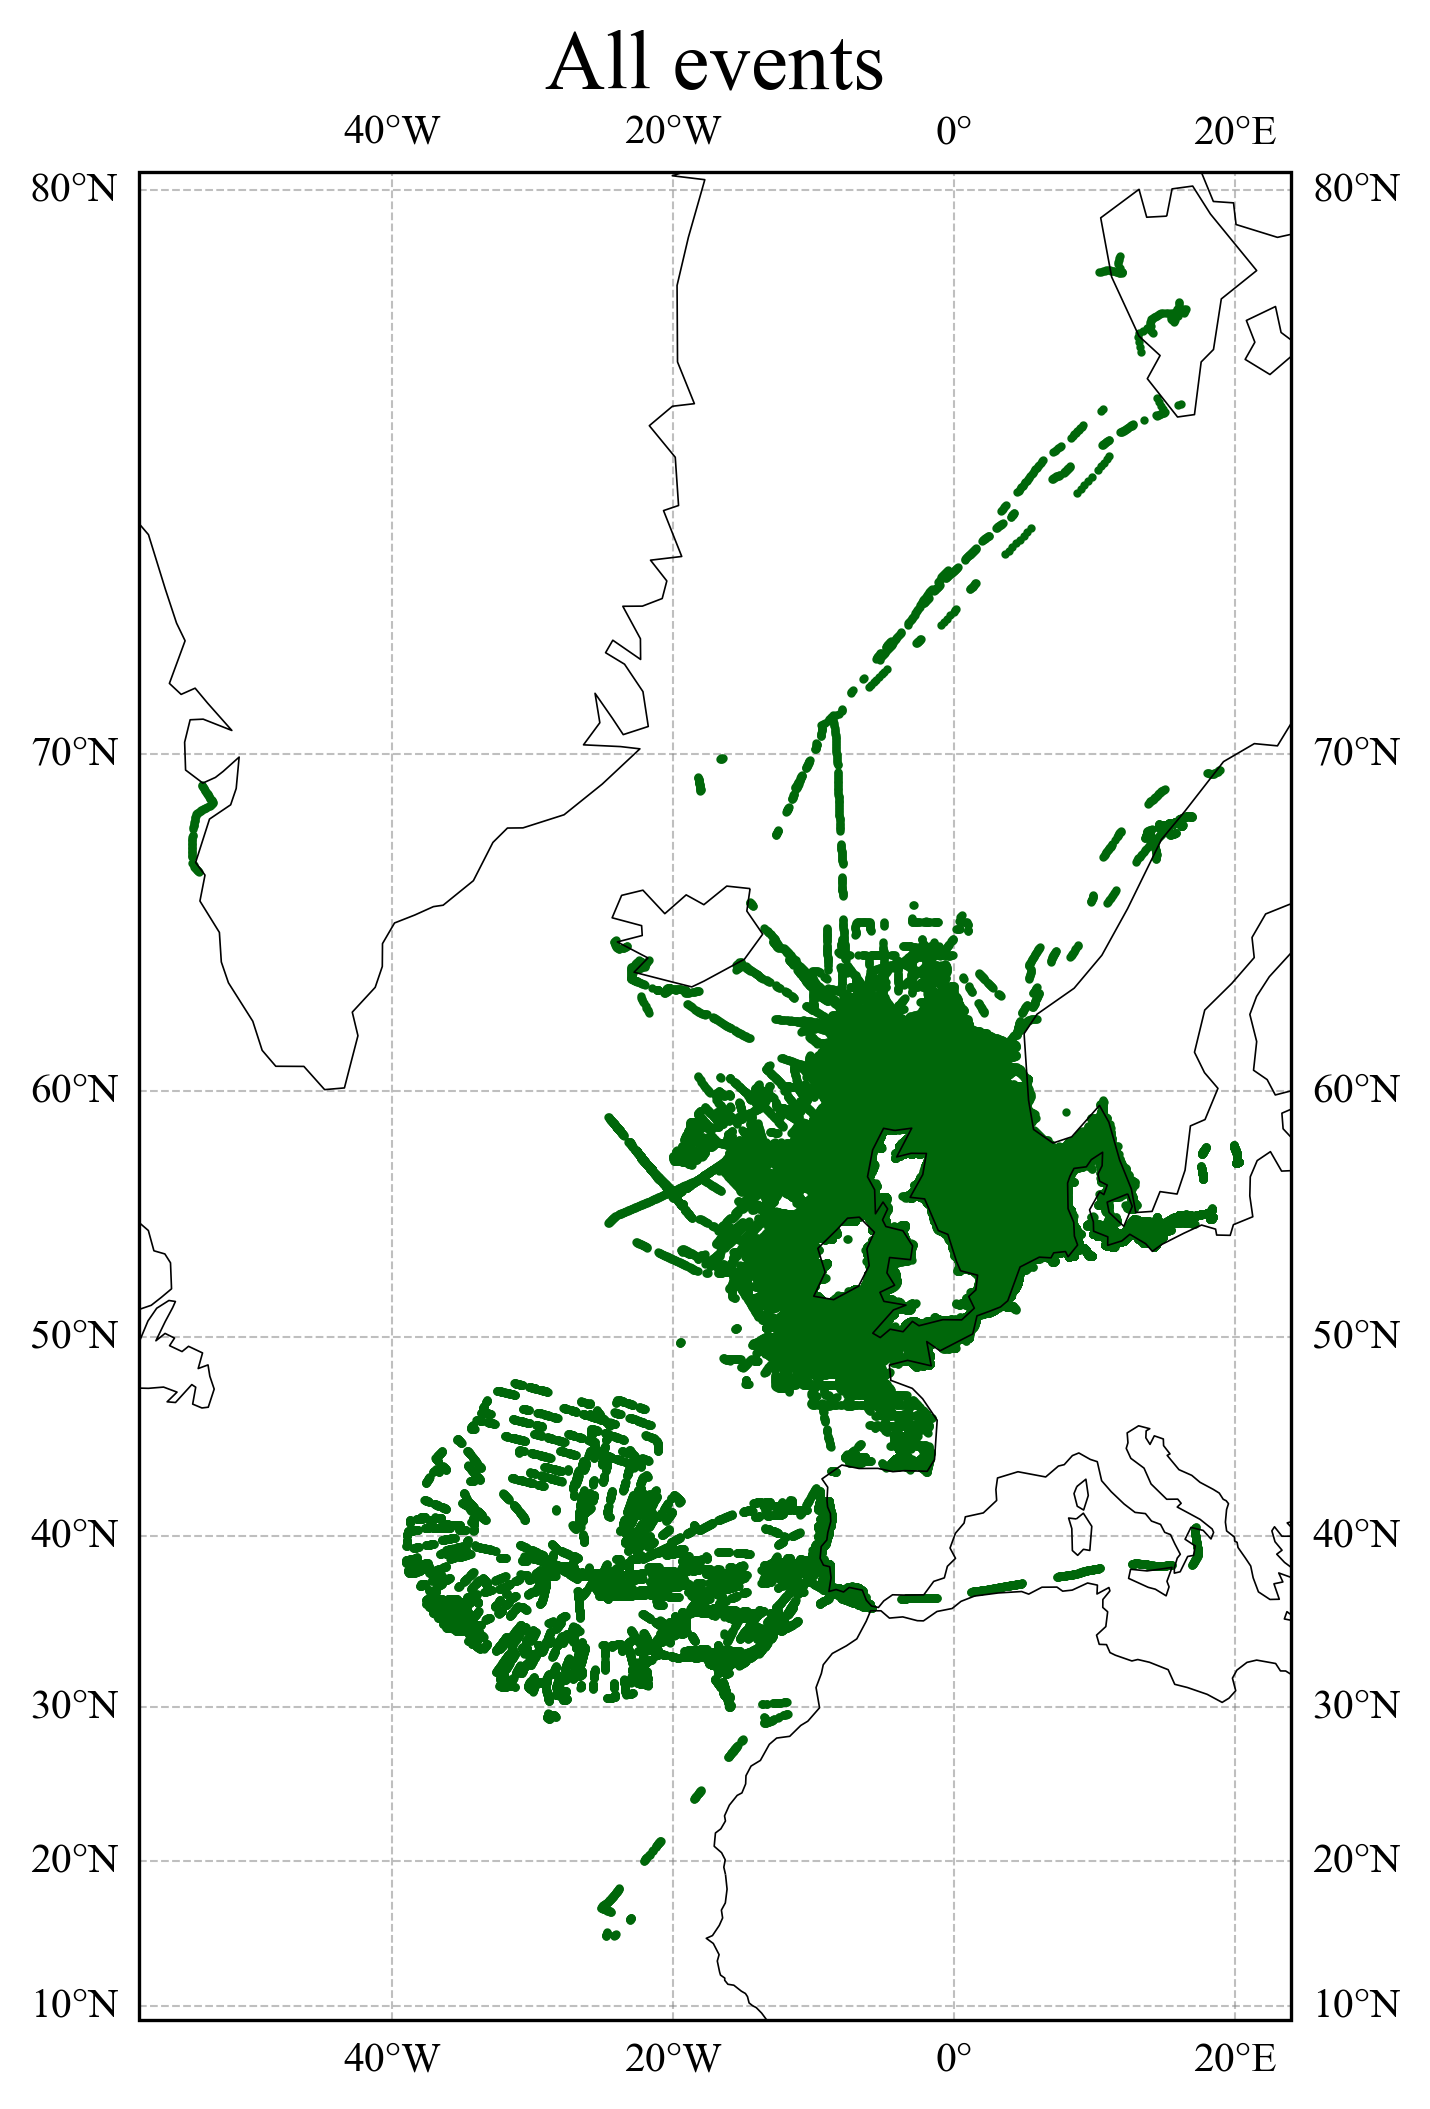

PyObject Text(0.5, 1.0318362183362202, 'All events')

In [6]:
if doplot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection=ccrs.Mercator())
    ax.plot(lon, lat, "o", color="#00670A", ms=1, transform=datacrs, zorder=3)
    ax.coastlines(lw=.4, zorder=4)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=0.5, linestyle="--")
    gl.xlabels_top = false
    gl.ylabels_right = false
    ax.set_title("All events")
end

In [7]:
function read_data_occurence(datafile::AbstractString)
    open(datafile, "r") do df
        firstline = readline(df)
        column_names = split(firstline, "\t")
        
        ncolumns = length(column_names)
        println(column_names)
        @info("Number of columns: $(ncolumns)")
        
        scientificName_column = findfirst(column_names .== "scientificName")
        eventID_column = findfirst(column_names .== "eventID")
        individualCount_column = findfirst(column_names .== "individualCount")

        individualCount = Int64[]
        scientificName = String[]
        eventID = String[]
       
        for lines in readlines(df)
            linesplit = split(lines, "\t")
            
            push!(scientificName, linesplit[scientificName_column])
            push!(eventID, linesplit[eventID_column])
            push!(individualCount, parse(Int64, linesplit[individualCount_column]))
        end
        
        
        return scientificName::Vector{String}, eventID::Vector{String}, individualCount::Vector{Int64}
    end
end

read_data_occurence (generic function with 1 method)

In [8]:
@info("Reading data from $(datafileoccur)")
scientificName, eventID_occurence, count = read_data_occurence(datafileoccur);

[ Info: Reading data from /home/ctroupin/data/EMODnet/Biology/dwca-esas-v1.3/occurrence.txt


SubString{String}["id", "basisOfRecord", "occurrenceID", "occurrenceRemarks", "individualCount", "sex", "lifeStage", "behavior", "occurrenceStatus", "associatedTaxa", "eventID", "scientificNameID", "scientificName", "kingdom", "vernacularName"]


[ Info: Number of columns: 15


In [9]:
scientificNameUnique = unique(scientificName);

Find the event ID corresponding to a given species. 

In [10]:
myspecies = "Larus fuscus"
speciesindex = findall(scientificName .== myspecies)
@info("Found $(length(speciesindex)) events for $(myspecies)")
speciesevent = eventID_occurence[speciesindex]
speciescount = count[speciesindex];

[ Info: Found 169215 events for Larus fuscus


In [15]:
@time specieseventUnique = unique(speciesevent);

  0.019622 seconds (43 allocations: 4.829 MiB)


In [45]:
@time findall(speciesevent .== specieseventUnique[33])

  0.002456 seconds (6 allocations: 16.016 KiB)


1-element Vector{Int64}:
 33

In [46]:
function dict_unique_indx(y)
    index_dict = Dict{eltype(y), Vector{Int}}()

    for (indx, element) in pairs(y)
        if haskey(index_dict, element)
            push!(index_dict[element], indx)
        else
            index_dict[element] = [indx]
        end
    end
    index_dict    
end

dict_unique_indx (generic function with 1 method)

In [57]:
@time indexDict = dict_unique_indx(speciesevent);
indexDict

  0.019849 seconds (94.55 k allocations: 11.437 MiB)


Dict{String, Vector{Int64}} with 94509 entries:
  "50000578_50000578_50052980"    => [63977]
  "50001717_50001717_50441644"    => [91620]
  "100002471_100002471_100002486" => [1059]
  "50000753_50000753_50166178"    => [67032]
  "110000357_110000357_110011885" => [17996]
  "50000763_50000763_50173171"    => [67932]
  "50000772_50000772_50091640"    => [68478]
  "10011742_10011742_10259874"    => [13268]
  "50001507_50001507_50370793"    => [85759]
  "50000496_50000496_50072733"    => [61731]
  "10002409_10002409_10034745"    => [3390]
  "50001243_50001243_50275524"    => [78273]
  "120018964_120018964_120019054" => [36754]
  "100000308_100000308_100000312" => [98]
  "110000066_110000066_110001795" => [15361]
  "10091_55000410_58438478"       => [14053]
  "50000522_50000522_50042244"    => [62423]
  "10002126_10002126_10030513"    => [3237]
  "50000707_50000707_50160212"    => [65929]
  "50001455_50001455_50348722"    => [83582]
  "110000690_110000690_110025685" => [22913]
  "50001137_5

In [29]:
numEvents = length(specieseventUnique)
@info("Found $(numEvents) unique events")
speciesCountTotal = zeros(Int64, numEvents)
speciesCountTotalDict = 

@time for (kkk, vvv) in indexDict
    # Find line indices
    #eventindex = findall(speciesevent .== ss)
    # Sum the count of those lines
    speciesCountTotal[iii] = sum(speciescount[eventindex])
end

[ Info: Found 94509 unique events


LoadError: TypeError: non-boolean (Int64) used in boolean context

Now we need to get the coordinates and times for the different events

In [ ]:
nevents = length(specieseventUnique)
lonspecies = Vector{Float64}(undef, nevents)
latspecies = Vector{Float64}(undef, nevents)
datesspecies = Vector{DateTime}(undef, nevents)

for (iii, sss) in enumerate(specieseventUnique)
    lineindex = findfirst(eventID .== sss)
    lonspecies[iii] = lon[lineindex]
    latspecies[iii] = lat[lineindex]
    datesspecies[iii] = dates[lineindex]
end

### Make plot to check

In [13]:
if doplot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection=ccrs.Mercator())
    ax.scatter(lonspecies, latspecies, s=3, c=speciesCountTotal, transform=datacrs)
    ax.coastlines(lw=.4)
    ax.set_extent(domain)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=0.5, linestyle="--")
    gl.xlabels_top = false
    gl.ylabels_right = false
    ax.set_title("Observations of $(myspecies)")
end

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ctroupin/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("'c' argument has 94509 elements, which is inconsistent with 'x' and 'y' with size 23603.")
  File "/home/ctroupin/.julia/conda/3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py", line 307, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ctroupin/.julia/conda/3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py", line 1683, in scatter
    result = super().scatter(*args, **kwargs)
  File "/home/ctroupin/.julia/conda/3/lib/python3.9/site-packages/matplotlib/__init__.py", line 1414, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/ctroupin/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 4386, in scatter
    self._parse_scatter_color_args(
  File "/home/ctroupin/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 4226, in _parse_scatter_color_args
    raise invalid_shape_exception(c.size, xsize) from err
